In [67]:
!pip install tensorflow_text

In [68]:
!pip install tensorflow_text
!pip install tf-models-official

In [123]:
!pip install tensorflow_hub==0.16.1
!pip install tf-keras

In [1]:
!pip install -U "tensorflow-text==2.15.*"
!pip install -U "tf-models-official==2.15.*"

In [2]:
import os
import warnings

warnings.filterwarnings("ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# Set `PATH` to include the directory containing saved_model_cli
PATH = %env PATH
%env PATH=/home/jupyter/.local/bin:{PATH}

env: PATH=/home/jupyter/.local/bin:/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin


In [4]:
import datetime
import shutil

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from google.cloud import aiplatform
from official.nlp import optimization  # to create AdamW optmizer

tf.get_logger().setLevel("ERROR")

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  1


In [6]:
import tarfile

url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
path = "/tmp"

# Download and extract manually
dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url, cache_dir=path, cache_subdir="", extract=False)
dataset_path = os.path.join(path, "datasets", "aclImdb_v1.tar.gz")

# Extract dataset if not already done
extracted_dir = os.path.join(path, "datasets", "aclImdb")
if not os.path.exists(extracted_dir):
    with tarfile.open(dataset, "r:gz") as tar:
        tar.extractall(path=os.path.join(path, "datasets"))
    print("Dataset extracted.")
else:
    print("Dataset already extracted.")

# Confirm paths
train_dir = os.path.join(extracted_dir, "train")
test_dir = os.path.join(extracted_dir, "test")

# Check if 'unsup' directory exists and remove it
remove_dir = os.path.join(train_dir, "unsup")
if os.path.exists(remove_dir):
    shutil.rmtree(remove_dir)
    print("Removed 'unsup' directory.")
else:
    print("'unsup' directory does not exist, skipping removal.")


Dataset already extracted.
'unsup' directory does not exist, skipping removal.


In [7]:
# Verify the structure of the extracted data
print("\nDirectory structure after extraction:")
for root, dirs, files in os.walk(extracted_dir):
    print(root, "contains directories:", dirs, "and files:", len(files))

# Set up the data loaders
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

# Load training data
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=seed,
)

# Retrieve class names from the dataset
class_names = raw_train_ds.class_names
print(f"Class names: {class_names}")


train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Load validation data
val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=seed,
)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Load test data
test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    test_dir,
    batch_size=batch_size
)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("\nData loaded successfully.")


Directory structure after extraction:
/tmp/datasets/aclImdb contains directories: ['test', 'train'] and files: 3
/tmp/datasets/aclImdb/test contains directories: ['pos', 'neg'] and files: 3
/tmp/datasets/aclImdb/test/pos contains directories: [] and files: 12500
/tmp/datasets/aclImdb/test/neg contains directories: [] and files: 12500
/tmp/datasets/aclImdb/train contains directories: ['pos', 'neg'] and files: 5
/tmp/datasets/aclImdb/train/pos contains directories: [] and files: 12500
/tmp/datasets/aclImdb/train/neg contains directories: [] and files: 12500
Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Class names: ['neg', 'pos']
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.

Data loaded successfully.


In [8]:
for text_batch, label_batch in train_ds.take(1):
    for i in range(3):
        print(f"Review: {text_batch.numpy()[i]}")
        label = label_batch.numpy()[i]
        print(f"Label : {label} ({class_names[label]})")

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)
Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they

In [9]:
# defining the URL of the smallBERT model to use
tfhub_handle_encoder = (
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"
)

# defining the corresponding preprocessing model for the BERT model above
tfhub_handle_preprocess = (
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
)

print(f"BERT model selected           : {tfhub_handle_encoder}")
print(f"Preprocess model auto-selected: {tfhub_handle_preprocess}")

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [10]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [11]:
text_test = ["this is such an amazing movie!"]
text_preprocessed = bert_preprocess_model(text_test)

# This print box will help you inspect the keys in the pre-processed dictionary
print(f"Keys       : {list(text_preprocessed.keys())}")

# 1. input_word_ids is the ids for the words in the tokenized sentence
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')

# 2. input_mask is the tokens which we are masking (masked language model)
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')

# 3. input_type_ids is the sentence id of the input sentence.
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [12]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [13]:
bert_results = bert_model(text_preprocessed)

print(f"Loaded BERT: {tfhub_handle_encoder}")
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.76262885  0.99280983 -0.18611874  0.3667385   0.1523372   0.6550446
  0.9681154  -0.94862705  0.0021616  -0.9877732   0.06842716 -0.97630596]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.2894634   0.34321257  0.33231494 ...  0.21300837  0.7102077
  -0.05771141]
 [-0.28742063  0.31981015 -0.23018579 ...  0.58455044 -0.21329722
   0.72692055]
 [-0.66157013  0.6887687  -0.87433    ...  0.10877256 -0.26173246
   0.47855335]
 ...
 [-0.2256114  -0.2892561  -0.0706443  ...  0.47565973  0.83277154
   0.40025324]
 [-0.29824266 -0.27473152 -0.05450485 ...  0.48849776  1.0955359
   0.18163376]
 [-0.4437817   0.00930699  0.07223739 ...  0.17290172  1.1833248
   0.07898028]]


In [14]:
import tensorflow as tf
import tensorflow_hub as hub

print("TensorFlow version:", tf.__version__)
print("TensorFlow Hub version:", hub.__version__)

TensorFlow version: 2.15.1
TensorFlow Hub version: 0.16.1


In [15]:
#Test the preprocessing layer independently
preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess)
preprocessed_text = preprocessing_layer(["Sample text for preprocessing"])
print("Preprocessed output:", preprocessed_text)

Preprocessed output: {'input_type_ids': <tf.Tensor: shape=(1, 128), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=int32)>, 'input_mask': <tf.Tensor: shape=(1, 128), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0,

In [16]:
#Ensure the BERT encoder accepts the processed input
encoder = hub.KerasLayer(tfhub_handle_encoder)
encoder_output = encoder(preprocessed_text)
print("Encoder output keys:", encoder_output.keys())

Encoder output keys: dict_keys(['pooled_output', 'sequence_output', 'encoder_outputs', 'default'])


In [30]:
import tensorflow as tf
import tensorflow_hub as hub

# Define the preprocessing and encoder handles
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/2"

# Load the preprocessing and encoder layers
preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name="preprocessing")
encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name="BERT_encoder")

# Build the model
def build_classifier_model(dropout_rate=0.1):
    # Define input layers for tokenized text
    input_word_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name="input_type_ids")

    # Encoder layer
    encoder_outputs = encoder({
        "input_word_ids": input_word_ids,
        "input_mask": input_mask,
        "input_type_ids": input_type_ids
    })

    # Classification head
    net = encoder_outputs["pooled_output"]
    net = tf.keras.layers.Dropout(dropout_rate)(net)
    net = tf.keras.layers.Dense(1, activation="sigmoid", name="classifier")(net)

    # Create the model
    return tf.keras.Model(inputs={
        "input_word_ids": input_word_ids,
        "input_mask": input_mask,
        "input_type_ids": input_type_ids
    }, outputs=net)

# Instantiate the model
dropout_rate = 0.15
classifier_model = build_classifier_model(dropout_rate)

# Compile the model
classifier_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Example text for prediction
text_test = ["This is an amazing movie!", "I didn't enjoy the story."]

# Preprocess the text using the preprocessing layer (this should be done before passing to the model)
preprocessed_text = preprocessing_layer(text_test)

# Preprocessed text will be a dictionary with keys 'input_word_ids', 'input_mask', 'input_type_ids'
# Convert preprocessed text into format accepted by the model for prediction

# Predict using the preprocessed input
bert_raw_result = classifier_model.predict({
    "input_word_ids": preprocessed_text["input_word_ids"],
    "input_mask": preprocessed_text["input_mask"],
    "input_type_ids": preprocessed_text["input_type_ids"]
})

print("Predictions:", bert_raw_result)

1/1 [==============================] - 0s 227ms/step
Predictions: [[0.5264189]
 [0.5643161]]


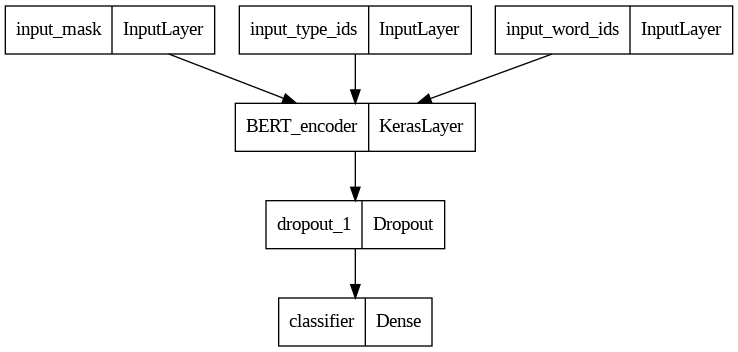

In [31]:
tf.keras.utils.plot_model(classifier_model)

In [32]:
loss = tf.keras.losses.BinaryCrossentropy()
metrics = tf.metrics.BinaryAccuracy()

In [33]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1 * num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(
    init_lr=init_lr,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    optimizer_type="adamw",
)

In [34]:
classifier_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [35]:
print(f"Training model with {tfhub_handle_encoder}")
history = classifier_model.fit(
    x=train_ds, validation_data=val_ds, epochs=epochs
)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/2
Epoch 1/5
625/625 [==============================] - 175s 179ms/step - loss: 0.4822 - binary_accuracy: 0.7624 - val_loss: 0.3671 - val_binary_accuracy: 0.8376
Epoch 2/5
625/625 [==============================] - 108s 173ms/step - loss: 0.3302 - binary_accuracy: 0.8591 - val_loss: 0.3591 - val_binary_accuracy: 0.8480
Epoch 3/5
625/625 [==============================] - 108s 173ms/step - loss: 0.2522 - binary_accuracy: 0.8967 - val_loss: 0.3935 - val_binary_accuracy: 0.8480
Epoch 4/5
625/625 [==============================] - 108s 173ms/step - loss: 0.1917 - binary_accuracy: 0.9267 - val_loss: 0.4411 - val_binary_accuracy: 0.8532
Epoch 5/5
625/625 [==============================] - 108s 173ms/step - loss: 0.1548 - binary_accuracy: 0.9419 - val_loss: 0.4665 - val_binary_accuracy: 0.8552


In [42]:
def preprocess_dataset(dataset):
    """
    Applies preprocessing to a dataset.

    Args:
        dataset: The dataset to preprocess.

    Returns:
        A preprocessed dataset.
    """
    # Create a list to store preprocessed batches
    preprocessed_batches = []
    for batch in dataset:
        # Extract the text from the batch
        text_batch = batch[0]

        # Preprocess the text
        preprocessed_batch = bert_preprocess_model(text_batch)

        # Store the preprocessed batch
        preprocessed_batches.append(preprocessed_batch)

    # Create a dictionary with the preprocessed data
    preprocessed_data = {
        "input_word_ids": tf.concat([batch["input_word_ids"] for batch in preprocessed_batches], axis=0),
        "input_mask": tf.concat([batch["input_mask"] for batch in preprocessed_batches], axis=0),
        "input_type_ids": tf.concat([batch["input_type_ids"] for batch in preprocessed_batches], axis=0),
    }

    # Create labels using tf.ones and tf.zeros for dummy dataset
    labels = tf.concat([tf.zeros(len(batch[0]), dtype=tf.int32) for batch in dataset], axis=0)


    # Return the preprocessed data
    return preprocessed_data, labels

# Preprocess the test data
preprocessed_test_data, test_labels = preprocess_dataset(test_ds)

# Evaluate the model using the preprocessed data
loss, accuracy = classifier_model.evaluate(preprocessed_test_data, test_labels)

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

782/782 [==============================] - 42s 53ms/step - loss: 2.5102 - binary_accuracy: 0.5042
Loss: 2.510166883468628
Accuracy: 0.5042399764060974


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


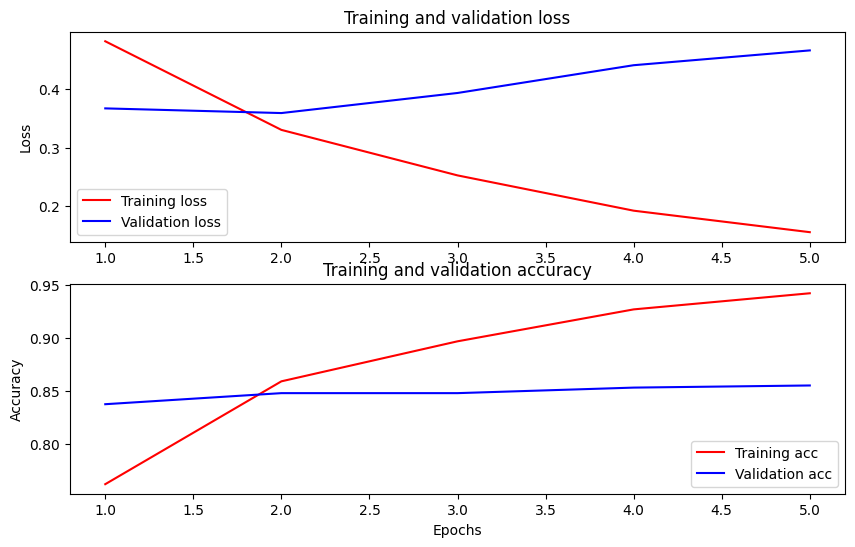

In [43]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict["binary_accuracy"]
val_acc = history_dict["val_binary_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, "r", label="Training loss")
# b is for "solid blue line"
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
# plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, "r", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

In [44]:
dataset_name = "imdb"
saved_model_path = "./{}_bert".format(dataset_name.replace("/", "_"))
TIMESTAMP = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

EXPORT_PATH = os.path.join(saved_model_path, TIMESTAMP)

classifier_model.save(EXPORT_PATH, include_optimizer=False)

In [45]:
reloaded_model = tf.saved_model.load(EXPORT_PATH)

In [49]:
def print_my_examples(inputs, results):
    result_for_printing = [
        f"input: {inputs[i]:<30} : score: {results[i][0]:.6f}"
        for i in range(len(inputs))
    ]
    print(*result_for_printing, sep="\n")
    print()


examples = [
    "this is such an amazing movie!",  # this is the same sentence tried earlier
    "The movie was great!",
    "The movie was meh.",
    "The movie was okish.",
    "The movie was terrible...",
]

# Preprocess the examples before feeding them to the reloaded model
preprocessed_examples_for_classifier = bert_preprocess_model(examples)

# Pass the preprocessed data to the classifier_model
original_results = classifier_model(
    {
        "input_word_ids": preprocessed_examples_for_classifier["input_word_ids"],
        "input_mask": preprocessed_examples_for_classifier["input_mask"],
        "input_type_ids": preprocessed_examples_for_classifier["input_type_ids"],
    }
)

print("Results from the saved model:")
print_my_examples(examples, reloaded_results)
print("Results from the model in memory:")
print_my_examples(examples, original_results)

Results from the saved model:
input: this is such an amazing movie! : score: 0.999599
input: The movie was great!           : score: 0.994319
input: The movie was meh.             : score: 0.931645
input: The movie was okish.           : score: 0.024237
input: The movie was terrible...      : score: 0.001012

Results from the model in memory:
input: this is such an amazing movie! : score: 0.999599
input: The movie was great!           : score: 0.994319
input: The movie was meh.             : score: 0.931645
input: The movie was okish.           : score: 0.024237
input: The movie was terrible...      : score: 0.001012

